In [77]:
import pandas as pd
import numpy as np
import random

# File operations
from copy import deepcopy
import glob
import os
from pathlib import Path

# Stats
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu
import statsmodels.stats.multitest

# Neuromaps
import neuromaps
from neuromaps.parcellate import Parcellater
from neuromaps import datasets, images, nulls, resampling, stats
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation, fetch_fslr
from enigmatoolbox.datasets import load_sc, load_fc
from nilearn.image import resample_to_img

# Set seed to 127
random.seed(127)

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [58]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(cowplot)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

Warning messages:
1: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
2: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
3: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
4: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in

# Load in the data and filter to Pearson correlation

In [59]:
data_path = "/Users/abry4213/data/HCP100/"
github_data_path = "/Users/abry4213/github/Homotopic_FC/data/"

#### GROUP-AVERAGED FUNCTIONAL CONNECTOME FROM ENIGMA #### 
# Load cortico-cortical functional connectivity data
fc_ctx, fc_ctx_labels, _, _ = load_fc(parcellation='aparc')

# Read in preprocessed Pearson-based functional connectivity data from ENIGMA
HCP_avg_Pearson_FC = (pd.DataFrame(fc_ctx, columns=fc_ctx_labels)
                      .assign(Brain_Region_From = fc_ctx_labels)
                      .melt(id_vars=["Brain_Region_From"], 
                             var_name="Brain_Region_To", 
                             value_name="Mean_Pearson_R")
                      .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.replace("L_", "").str.replace("R_", ""),
                              Base_Region_To = lambda x: x['Brain_Region_To'].str.replace("L_", "").str.replace("R_", ""),
                              Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.startswith("L_"), "Left", "Right"),
                              Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.startswith("L_"), "Left", "Right"))
)
pearson_homotopic_res_mean = (HCP_avg_Pearson_FC
                              .query("Base_Region_From == Base_Region_To")
                              .groupby(["Base_Region_From"])['Mean_Pearson_R']
                              .mean() 
                              .reset_index()
                              .rename(columns={"Base_Region_From": "Base_Region"})
                              )

sc_ctx, sc_ctx_labels, _, _ = load_sc(parcellation='aparc')

HCP_avg_Pearson_SC = (pd.DataFrame(sc_ctx, columns=sc_ctx_labels)
                      .assign(Brain_Region_From = sc_ctx_labels)
                      .melt(id_vars=["Brain_Region_From"], 
                             var_name="Brain_Region_To", 
                             value_name="Mean_Num_Streamlines")
                      .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.replace("L_", "").str.replace("R_", ""),
                              Base_Region_To = lambda x: x['Brain_Region_To'].str.replace("L_", "").str.replace("R_", ""),
                              Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.startswith("L_"), "Left", "Right"),
                              Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.startswith("L_"), "Left", "Right"))
)

SC_homotopic_res_mean = (HCP_avg_Pearson_SC
                            .query("Base_Region_From == Base_Region_To")
                            .groupby(["Base_Region_From"])['Mean_Num_Streamlines']
                            .mean() 
                            .reset_index()
                            .rename(columns={"Base_Region_From": "Base_Region"})
                            .rename(columns={"Mean_Num_Streamlines": "Value"})
                            .assign(Category = "Microstructure", Description = "Log-SC")
                            )

# Read in brain region lookup table
brain_region_info = pd.read_csv("../data/Brain_Region_Info.csv")
fsaverage_data_base_path = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage"

all_centroid_res_list = []
for hemi in ["lh", "rh"]:

    # Load annotation file (parcellation)
    annot_path = f"{fsaverage_data_base_path}/{hemi}.aparc.annot"
    labels, ctab, names = fs.read_annot(annot_path)

    # Load label file (vertex coordinates)
    label_path = f"{fsaverage_data_base_path}/{hemi}.aparc.label"
    vertices = fs.read_label(label_path)

    # Load the FreeSurfer surface (to get vertex coordinates)
    pial_path = f"{fsaverage_data_base_path}/{hemi}.pial"
    surf = fs.read_geometry(pial_path)
    coords, faces = surf
    cort = np.sort(fs.read_label(f"{fsaverage_data_base_path}/{hemi}.cortex.label"))

    # Create a dictionary to store centroids
    roi_centroids = {}

    # Compute centroids for each ROI
    for i, roi_name in enumerate(names):
        roi_vertices = np.where(labels == i)[0]  # Get vertex indices in this ROI
        if len(roi_vertices) > 0:
            roi_centroids[roi_name] = coords[roi_vertices].mean(axis=0)  # Mean position

    # Convert centroids to DataFrame
    centroid_df = pd.DataFrame(roi_centroids).T
    centroid_df.columns = ["x", "y", "z"]

    # Convert names to strings, dropping corpuscallosum
    names_dec = [name.decode() for name in names if name.decode() not in ["corpuscallosum"]]

    # If centroid_df has 34 rows, drop 'unknown' from names
    if centroid_df.shape[0] == 34:
        names_dec = [name for name in names_dec if name != "unknown"]

    # Add region names and hemisphere
    centroid_df = (centroid_df.reset_index(drop=True).assign(Base_Region=names_dec, 
                                                             Hemisphere=np.where(hemi == "lh", "Left", "Right"))
                                                     .assign(Brain_Region = lambda x: hemi + '-' + x['Base_Region']))

    # Append to list
    all_centroid_res_list.append(centroid_df)

# Concatenate the results
all_centroid_res = pd.concat(all_centroid_res_list).query("Base_Region != 'unknown'")

# Compute Euclidean distances between all ROI centroids
dist_matrix = cdist(all_centroid_res[['x', 'y', 'z']], all_centroid_res[['x', 'y', 'z']], metric="euclidean")

# Convert to DataFrame
euclidean_dist_df = (pd.DataFrame(dist_matrix, index=all_centroid_res['Brain_Region'], 
                        columns=all_centroid_res['Brain_Region'])
                        .reset_index()
                        .rename(columns={"Brain_Region": "Brain_Region_From"})
                        .melt(id_vars='Brain_Region_From', var_name='Brain_Region_To', value_name='Euclidean_Distance')
                        .query("Brain_Region_From != Brain_Region_To")
                        .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.split('-').str[1],
                                Base_Region_To = lambda x: x['Brain_Region_To'].str.split('-').str[1],
                                Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.split('-').str[0]=='lh', 'Left', 'Right'),
                                Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.split('-').str[0]=='lh', 'Left', 'Right'))
                        )

# Filter to just the homotopic regions
homotopic_euclidean_dist_df = (euclidean_dist_df.query("Base_Region_From == Base_Region_To").drop_duplicates(subset=['Base_Region_To', 'Euclidean_Distance'])
                               .filter(['Base_Region_To', 'Euclidean_Distance'])
                               .rename(columns={"Base_Region_To": "Base_Region",
                                                "Euclidean_Distance": "Value"})
                               .assign(Category = "Microstructure", Description = "Euclidean Distance")
                               )

# Merge the results
structural_data = (pd.concat([homotopic_euclidean_dist_df, SC_homotopic_res_mean])
                           .merge(pearson_homotopic_res_mean, on="Base_Region", how="left"))

structural_data = (structural_data
 .pivot(index=["Base_Region"], columns=['Description'], values=['Value'])
 .reset_index()
 .rename(columns={"Euclidean Distance": "Euclidean_dist",
                  "Log-SC": "Log_SC"})
)

# Set index to 1 level
structural_data.columns = structural_data.columns.map(lambda x: x[1] if isinstance(x, tuple) else x)
structural_data.reset_index(drop=True, inplace=True)
structural_data.columns = ['Base_Region', 'Euclidean_dist', 'Log_SC']

In [60]:
structural_data.head()

,Base_Region,Euclidean_dist,Log_SC
0,bankssts,107.295679,0.000000
1,caudalanteriorcingulate,8.872718,4.218869
2,caudalmiddlefrontal,71.263939,4.821796
3,cuneus,14.742938,3.938943
4,entorhinal,46.750266,1.639767


In [62]:
# Regional volume data
regional_volumes = pd.read_csv(f"{data_path}/raw_data/structural_MRI/HCP100_all_dk_volumes.csv")
regional_volumes_mean = (regional_volumes
                         .groupby('Region')['Volume']
                         .agg(['mean', 'std'])
                         .reset_index()
                         .rename(columns={"Region": "Region_Index", "mean": "Mean_Volume", "std": "SD_Volume"})
                         .assign(Region_Index = lambda x: x.Region_Index.astype(int))
                         .merge(brain_region_info, on="Region_Index", how="left")
)

regional_volumes_mean_hemi_avg = (regional_volumes
    .rename(columns={"Region": "Region_Index"})
    .merge(brain_region_info, on="Region_Index", how="left")
    .groupby('Base_Region')['Volume']
    .agg(['mean'])
    .reset_index()
    .rename(columns={"mean": "Value"})
    .sort_values('Base_Region')
)
structural_data['Regional_volume'] = regional_volumes_mean_hemi_avg['Value']

In [63]:
# Associations with vascular density
if not os.path.isfile(f"{github_data_path}/Arterial_Venous_Mean_Density_aparc.csv"):

    # aparc + aseg volume
    ROI_image = nib.load("/Users/abry4213/data/neuroimaging_atlases/volumes/freesurfer_segmentations/mni152_space/atlas-desikankilliany.nii.gz")
    ROI_lookup = pd.read_csv("/Users/abry4213/data/neuroimaging_atlases/volumes/freesurfer_segmentations/mni152_space/atlas-desikankilliany.csv")

    # Read in vasculature volumes (arterial and venous)
    arterial_image = nib.load(f"{github_data_path}/vasculature/mean_Ved_ToF_filt.nii.gz")
    venous_image = nib.load(f"{github_data_path}/vasculature/mean_Ved_swi_filt.nii.gz")

    # Downsample the segmentation volume to match the vasculature images
    ROI_image_resampled = resample_to_img(ROI_image, arterial_image, interpolation='nearest')
    ROI_data_resampled = ROI_image_resampled.get_fdata().flatten()

    # Extract data arrays
    venous_data = venous_image.get_fdata().flatten()
    arterial_data = arterial_image.get_fdata().flatten()

    ROI_indices = [int(i) for i in np.unique(ROI_data_resampled) if i != 0]

    regional_vascular_data_list = [] 

    for this_index in ROI_indices:
        region_info = ROI_lookup.query("id == @this_index")[['id', 'label', 'hemisphere']]

        arterial_roi_data = np.mean(arterial_data[ROI_data_resampled == this_index])
        venous_roi_data = np.mean(venous_data[ROI_data_resampled == this_index])

        ROI_vascular_df = pd.DataFrame({"id": this_index,
                                        "Arterial_Vascular": arterial_roi_data,
                                        "Venous_Vascular": venous_roi_data}, index=[0]).merge(region_info, on='id', how='left')
        
        regional_vascular_data_list.append(ROI_vascular_df)

    regional_vascular_data = (pd.concat(regional_vascular_data_list, ignore_index=True)
                            .rename(columns={"label": "Base_Region",
                                            'hemisphere': "Hemisphere"})
    )

    # Save to CSV
    regional_vascular_data.to_csv(f"{github_data_path}/Arterial_Venous_Mean_Density_aparc.csv", index=False)

else: 
    regional_vascular_data = pd.read_csv(f"{github_data_path}/Arterial_Venous_Mean_Density_aparc.csv")

# Take the mean of left/right
regional_vascular_data = (regional_vascular_data.groupby(['Base_Region'])[['Arterial_Vascular', 'Venous_Vascular']]
                          .mean()
                          .reset_index()
)

# Add to structural data
structural_data = structural_data.merge(regional_vascular_data, on='Base_Region', how='left').merge(pearson_homotopic_res_mean, on='Base_Region', how='left')
structural_data.head()

,Base_Region,Euclidean_dist,Log_SC,Regional_volume,Arterial_Vascular,Venous_Vascular,Mean_Pearson_R
0,bankssts,107.295679,0.000000,1046.970,5.629985,39.885609,0.314670
1,caudalanteriorcingulate,8.872718,4.218869,388.690,20.057773,38.279240,0.213912
2,caudalmiddlefrontal,71.263939,4.821796,364.960,17.089778,32.134382,0.330858
3,cuneus,14.742938,3.938943,993.025,15.818715,69.034659,0.644840
4,entorhinal,46.750266,1.639767,507.115,27.140752,80.060211,0.029524


Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


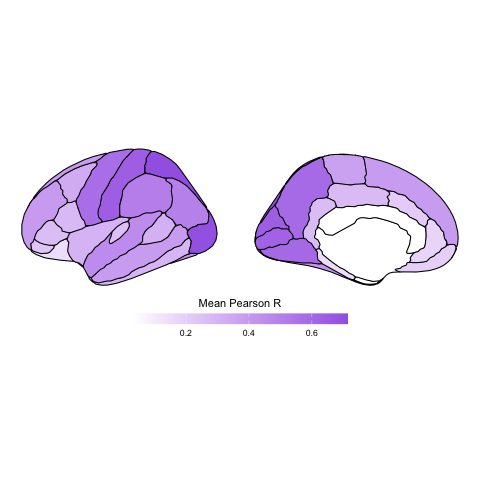

In [64]:
%%R -i pearson_homotopic_res_mean

# Plot mean HoFC in purple
### Pearson FC in brain ###
pearson_homotopic_res_mean %>%
  ungroup() %>%
  mutate(label = glue("lh_{Base_Region}")) %>%
  left_join(., as_tibble(dk)) %>%
  ggseg(atlas = dk, mapping = aes(fill = Mean_Pearson_R),
        position = "stacked", colour = "black", hemisphere="left",
        linewidth=0.5) +
  theme_void() +
  labs(fill = "Mean Pearson R") +
      theme(plot.title = element_blank(),
            legend.key.width  = unit(3, "lines"),
            legend.key.height  = unit(0.75, "lines"),
            legend.position = "bottom") +
            guides(fill = guide_colorbar(title.position="top", title.hjust=0.5)) +
    scale_fill_gradient(low='white', high='#A469E6', na.value='white')
# ggsave("../plots/measure_maps/Mean_LR_averaged_Pearson_R_ggseg.svg", width = 4, height = 3)

## Is the magnitude of homotopic Pearson FC across brain regions tied to (1) Euclidean distance between the two regions and/or (2) the number of streamlines between those two regions on average?

### Calculate Euclidean, geodesic, and fiber connectivity distances between each region--region pair

In [71]:
%%R -i structural_data

colormap <- setNames(c("#5c9335", "#10b8e8", "#F1D201", "#e24528", "#d41d56"), 
                     c('Euclidean_dist', 'Log_SC', 'Regional_volume', 'Arterial_Vascular', 'Venous_Vascular'))

all_scatter_plots_list <- list()

for (i in 1:length(colormap)) {
      this_color <- colormap[i]
      this_map <- names(colormap[i])
      print(this_map)
      this_scatter_plot <- structural_data %>%
            dplyr::rename("Value" = this_map) %>%
            ggplot(aes(x=Value, y=Mean_Pearson_R, fill=Value)) +
            geom_point(color='black', shape=21, size=4) +
            scale_fill_gradient(low="white", high=this_color, na.value="white")+
            geom_smooth(method="lm", se=FALSE, color='black') +
            ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
            xlab(sprintf("Mean %s", this_map)) +
            ylab("Mean Pearson R") +
            theme(legend.position="none",
                  axis.text = element_text(size=16),
                  axis.title = element_text(size=16))

      all_scatter_plots_list[[i]] <- this_scatter_plot
}

wrap_plots(all_scatter_plots_list, ncol=1)

ggsave("../plots/measure_maps/Mean_Pearson_R_magnitude_vs_structural_vascular_scatters.svg", width=3.5, height=14, dpi=300, units="in")

[1] "Euclidean_dist"
[1] "Log_SC"
[1] "Regional_volume"
[1] "Arterial_Vascular"
[1] "Venous_Vascular"
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


In addition: Warning messages:
1: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
2: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
3: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
4: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping

### Plot the SC/Euclidean distance per region in the brain

In [ ]:
%%R -i structural_data

all_ggseg_plots_list <- list()

colormap <- setNames(c("#5c9335", "#10b8e8"), c('Euclidean Distance', 'Log-SC'))

for (desc in unique(structural_data$Description)) {
      desc_color <- colormap[desc]

      desc_p <- structural_data %>%
            filter(Description==desc) %>% 
            mutate(label = glue("lh_{Base_Region}")) %>%
            left_join(., as_tibble(dk)) %>%
            ggseg(atlas = dk, mapping = aes(fill = Value),
                  position = "stacked", colour = "black", hemisphere="left",
                  linewidth=0.5) +
            theme_void() +
            labs(fill = desc) +
            scale_fill_gradient(low="white", high=desc_color, na.value="white")+
            theme(plot.title = element_blank(),
            legend.key.width  = unit(3, "lines"),
            legend.key.height  = unit(0.75, "lines"),
            legend.position = "bottom") +
            guides(fill = guide_colorbar(title.position="top", title.hjust=0.5))

      all_ggseg_plots_list[[desc]] <- desc_p
}

wrap_plots(all_ggseg_plots_list, ncol=1)
# ggsave("../plots/measure_maps/structural_data_ggseg_res.svg", width=4, height=4, dpi=300, units="in")


In [74]:
%%R -i structural_data

colormap <- setNames(c("#5c9335", "#10b8e8", "#F1D201", "#e24528", "#d41d56"), 
                     c('Euclidean_dist', 'Log_SC', 'Regional_volume', 'Arterial_Vascular', 'Venous_Vascular'))

all_ggseg_plots_list <- list()

for (i in 1:length(colormap)) {
      this_color <- colormap[i]
      this_map <- names(colormap[i])
      print(this_map)
      desc_p <- structural_data %>%
            dplyr::rename("Value" = this_map) %>%
            mutate(label = glue("lh_{Base_Region}")) %>%
            left_join(., as_tibble(dk)) %>%
            ggseg(atlas = dk, mapping = aes(fill = Value),
                  position = "stacked", colour = "black", hemisphere="left",
                  linewidth=0.5) +
            theme_void() +
            labs(fill = this_map) +
            scale_fill_gradient(low="white", high=this_color, na.value="white")+
            theme(plot.title = element_blank(),
            legend.key.width  = unit(3, "lines"),
            legend.key.height  = unit(0.75, "lines"),
            legend.position = "bottom") +
            guides(fill = guide_colorbar(title.position="top", title.hjust=0.5))

      all_ggseg_plots_list[[i]] <- desc_p
}

wrap_plots(all_ggseg_plots_list, ncol=1)

ggsave("../plots/measure_maps/Mean_Pearson_R_magnitude_vs_structural_vascular_ggseg.svg", width=3.5, height=10, dpi=300, units="in")

[1] "Euclidean_dist"
Joining with `by = join_by(label)`
[1] "Log_SC"
Joining with `by = join_by(label)`
[1] "Regional_volume"
Joining with `by = join_by(label)`
[1] "Arterial_Vascular"
Joining with `by = join_by(label)`
[1] "Venous_Vascular"
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


# Spin tests

In [75]:
structural_data.head()

,Base_Region,Euclidean_dist,Log_SC,Regional_volume,Arterial_Vascular,Venous_Vascular,Mean_Pearson_R
0,bankssts,107.295679,0.000000,1046.970,5.629985,39.885609,0.314670
1,caudalanteriorcingulate,8.872718,4.218869,388.690,20.057773,38.279240,0.213912
2,caudalmiddlefrontal,71.263939,4.821796,364.960,17.089778,32.134382,0.330858
3,cuneus,14.742938,3.938943,993.025,15.818715,69.034659,0.644840
4,entorhinal,46.750266,1.639767,507.115,27.140752,80.060211,0.029524


In [84]:
# Define the left- and right-hemisphere Desikan-Killiany (DK) atlas
lh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/lh.aparc.annot"
rh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/rh.aparc.annot"

# Convert the DK atlas to gifti format
# dk_gifti = neuromaps.images.annot_to_gifti((lh_dk, rh_dk), background=None)
dk_gifti = neuromaps.images.annot_to_gifti(lh_dk, background=None)
dk_gifti = neuromaps.images.relabel_gifti(dk_gifti)

# Fit a Parcellator object
dk_parc = Parcellater(dk_gifti, 'fsLR', resampling_target='parcellation', hemi='L')

# Create a dictionary of values to compare
struct_measures_dict = {'Euclidean_dist': structural_data['Euclidean_dist'].values,
                           'Log_SC': structural_data['Log_SC'].values,
                           'Regional_volume': structural_data['Regional_volume'].values,
                           'Arterial_Vascular': structural_data['Arterial_Vascular'].values,
                           'Venous_Vascular': structural_data['Venous_Vascular'].values}

rng = np.random.default_rng(seed=127)  # for reproducibility
HoFC_measure = structural_data['Mean_Pearson_R'].values

# Assume you are working with fsaverage and the Desikan-Killiany atlas
atlas = 'fsLR'

spin_test_df_list = []

for key, value in struct_measures_dict.items():
    comparison_values = struct_measures_dict[key]

    # Use DEF to generate the nulls
    spins = nulls.alexander_bloch(comparison_values, atlas=atlas, parcellation=dk_gifti, density='164k',
                                n_perm=10000, seed=127)

    # Step 4: Compare ABC and DEF using the nulls
    stat, p = spearmanr(HoFC_measure, comparison_values)
    stat_spin, p_spin = stats.compare_images(HoFC_measure, comparison_values, ignore_zero=False, nulls=spins, metric='spearmanr')

    # this_map
    this_map_spin_res = pd.DataFrame({"Comparison": key, 
                                      "SpearmanR": stat, 
                                      "pval": p,
                                      "SpearmanR_spin": stat_spin,
                                      "pval_spin": p_spin}, index=[0])
    spin_test_df_list.append(this_map_spin_res)
    
spin_test_df = pd.concat(spin_test_df_list)
spin_test_df

,Comparison,SpearmanR,pval,SpearmanR_spin,pval_spin
0,Euclidean_dist,0.161192,0.362443,0.161192,0.253775
0,Log_SC,0.115618,0.514960,0.115618,0.488551
0,Regional_volume,0.098549,0.579243,0.098549,0.630237
0,Arterial_Vascular,-0.353705,0.040154,-0.353705,0.007499
0,Venous_Vascular,-0.084186,0.635951,-0.084186,0.801720


In [79]:
log_SC_data = structural_data.Log_SC.values

spearmanr(log_SC_data, HoFC_measure)

SignificanceResult(statistic=np.float64(0.11561772472388285), pvalue=np.float64(0.5149599652613539))